# Quantum PyTorch Connector

Qiskit is an open source SDK for working with quantum computers at the level of pulses, circuits and application modules. 

This tutorial shows how the `TorchConnector` allows to use any `NeuralNetwork` from Qiskit Machine Learning and integrate it in a PyTorch workflow. The `TorchConnector` takes any `NeuralNetwork` and makes it available as a PyTorch `Module`.

## Content:

[Part 1: Simple Classification & Regression](#Part-1:-Simple-Classification-&-Regression)
- Classification
    - Classification with PyTorch and the `OpflowQNN`
    - Classification with PyTorch and the `CircuitQNN`
- Regression
    - Regression with PyTorch and the `OpflowQNN`

[Part 2: MNIST Classification](#Part-2:-MNIST-Classification)

Illustrates how to embed a (Quantum) `NeuralNetwork` into a target PyTorch workflow to classify MNIST data.

## Import the libraries
The Machine Learning package simply contains sample datasets at present. It has some classification algorithms such as QSVM and VQC (Variational Quantum Classifier), where this data can be used for experiments, and there is also QGAN (Quantum Generative Adversarial Network) algorithm.

### Installation
We encourage installing Qiskit, PyTorch, and Qiskit Machine Learning via the pip tool (a python package manager).

pip will handle all dependencies automatically and you will always install the latest (and well-tested) version.

If you want to work on the very latest work-in-progress versions, learn more about Qiskit, or if you want to contribute to Qiskit Machine Learning visit `qiskit.org` for more information

In [1]:
pip install -q qiskit

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install -q qiskit_machine_learning

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit  import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

qi = QuantumInstance(Aer.get_backend('statevector_simulator'))

### [Optional] Setup token to run the experiment on a real device

If you would like to run the experiment on a real device, you need to setup your account first. Visit `quantum-computing.ibm.com` to create an account and get an API Token.

Note: If you do not store your token yet, use IBMQ.save_account('MY_API_TOKEN') in the above cell to store it.

# Part 1: Simple Classification & Regression

## Classification

First, we show how the `TorchConnector` can be used to use a Quantum `NeuralNetwork` to solve a classification tasks. Therefore, we generate a simple random data set.

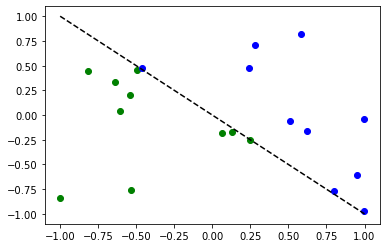

In [5]:
num_inputs = 2
num_samples = 20
X = 2*np.random.rand(num_samples, num_inputs) - 1
y01 = 1*(np.sum(X, axis=1) >= 0)  # in { 0,  1}
y = 2*y01-1                       # in {-1, +1}

X_ = Tensor(X)
y01_ = Tensor(y01).reshape(len(y)).long()
y_ = Tensor(y).reshape(len(y), 1)

for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

### Classification with PyTorch and the `OpflowQNN`

Linking an `OpflowQNN` to PyTorch is relatively straight-forward. Here we illustrate this using the `TwoLayerQNN`.

In [6]:
# set up QNN
qnn1 = TwoLayerQNN(num_qubits=num_inputs, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn1.num_weights) - 1)
model1 = TorchConnector(qnn1, initial_weights=initial_weights)

In [7]:
# test with a single input
model1(X_[0, :])

tensor([0.4870], grad_fn=<_TorchNNFunctionBackward>)

In [8]:
# define optimizer and loss
optimizer = LBFGS(model1.parameters())
f_loss = MSELoss(reduction='sum')

# start training
model1.train()   # set model to training mode

# define objective function
def closure():
    optimizer.zero_grad()          # initialize gradient
    loss = f_loss(model1(X_), y_)  # evaluate loss function
    loss.backward()                # backward pass
    print(loss.item())             # print loss
    return loss

# run optimizer
optimizer.step(closure)

23.32431983947754
22.417186737060547
22.099637985229492
22.038938522338867
21.931228637695312
21.70505142211914
21.207923889160156
20.16400909423828
18.451244354248047
16.941734313964844
16.621835708618164
16.09764289855957
16.072778701782227
16.04912567138672
16.032245635986328
16.026954650878906
16.02686309814453
16.02686309814453


tensor(23.3243, grad_fn=<MseLossBackward>)

Accuracy: 0.65


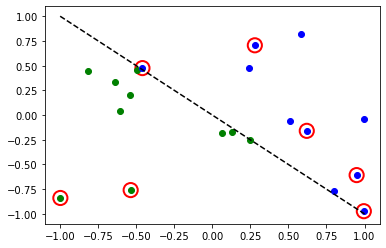

In [9]:
# evaluate model and compute accuracy
y_predict = []
for x, y_target in zip(X, y):
    output = model1(Tensor(x))
    y_predict += [np.sign(output.detach().numpy())[0]]

print('Accuracy:', sum(y_predict == y)/len(y))

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

The red circles indicate wrongly classified data points.

### Classification with PyTorch and the `CircuitQNN`

Linking an `CircuitQNN` to PyTorch requires the correct setup, otherwise backpropagation is not possible.

In [10]:
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs, entanglement='linear', reps=1)

qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: '{:b}'.format(x).count('1') % 2
output_shape = 2  # parity = 0, 1

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)

In [11]:
# define model, optimizer, and loss
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()

# start training
model2.train()    
def closure():
    optimizer.zero_grad(set_to_none=True)                  # initialize gradient
    
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())  # calculate loss
        
    loss.backward()                                        # backward pass
    
    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);

14.32850170135498
13.924478530883789
13.681212425231934
13.024215698242188
13.755447387695312
13.578914642333984
14.451342582702637
13.371788024902344
14.106246948242188
13.475948333740234
12.610498428344727
13.876771926879883
14.131065368652344
15.041966438293457
13.904813766479492
15.216582298278809
14.505072593688965
14.113485336303711
14.147229194641113
12.834684371948242


Accuracy: 0.5


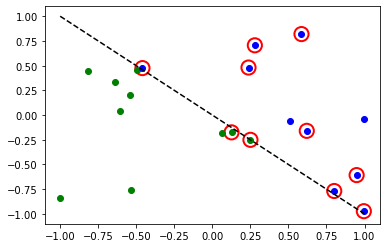

In [12]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == y01)/len(y01))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

## Regression 

We use a model based on the `TwoLayerQNN` to also illustrate an regression task.

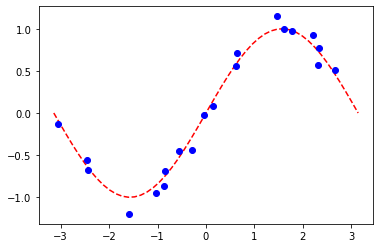

In [13]:
num_samples = 20
eps = 0.2
lb, ub = -np.pi, np.pi
f = lambda x: np.sin(x)

X = (ub - lb)*np.random.rand(num_samples, 1) + lb
y = f(X) + eps*(2*np.random.rand(num_samples, 1)-1)
plt.plot(np.linspace(lb, ub), f(np.linspace(lb, ub)), 'r--')
plt.plot(X, y, 'bo')
plt.show()

In [14]:
# construct simple feature map
param_x = Parameter('x')
feature_map = QuantumCircuit(1, name='fm')
feature_map.ry(param_x, 0)

# construct simple feature map
param_y = Parameter('y')
ansatz = QuantumCircuit(1, name='vf')
ansatz.ry(param_y, 0)

# construct QNN
qnn3 = TwoLayerQNN(1, feature_map, ansatz, quantum_instance=qi)
print(qnn3.operator)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn3.num_weights) - 1)
model3 = TorchConnector(qnn3, initial_weights)

ComposedOp([
  OperatorMeasurement(1.0 * Z),
  CircuitStateFn(
       ┌───────┐┌───────┐
  q_0: ┤ fm(x) ├┤ vf(y) ├
       └───────┘└───────┘
  )
])


In [15]:
# define optimizer and loss function
optimizer = LBFGS(model3.parameters())
f_loss = MSELoss(reduction='sum')

# start training
model3.train()   # set model to training mode

# define objective function
def closure():
    optimizer.zero_grad(set_to_none=True)        # initialize gradient
    loss = f_loss(model3(Tensor(X)), Tensor(y))  # compute batch loss
    loss.backward()                              # backward pass    
    print(loss.item())                           # print loss
    return loss

# run optimizer
optimizer.step(closure)

23.776588439941406
3.201629877090454
1.9335451126098633
0.21675428748130798
0.18783260881900787
0.18689607083797455
0.18689584732055664


tensor(23.7766, grad_fn=<MseLossBackward>)

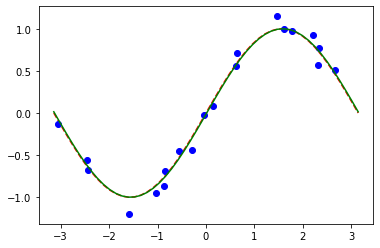

In [16]:
# plot target function
plt.plot(np.linspace(lb, ub), f(np.linspace(lb, ub)), 'r--')

# plot data
plt.plot(X, y, 'bo')

# plot fitted line
y_ = []
for x in np.linspace(lb, ub):
    output = model3(Tensor([x]))
    y_ += [output.detach().numpy()[0]]
plt.plot(np.linspace(lb, ub), y_, 'g-')
plt.show()

# Part 2: MNIST Classification 
Also see Qiskit Textbook: https://qiskit.org/textbook/ch-machine-learning/machine-learning-qiskit-pytorch.html

In [17]:
from torch import cat, no_grad 
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (Module, Conv2d, Linear, Dropout2d, NLLLoss, 
                     MaxPool2d, Flatten, Sequential, ReLU)
import torch.nn.functional as F

In [18]:
# Concentrating on the first 100 samples
batch_size = 1
n_samples = 100

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1 
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)

0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch-base_1628832796132/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


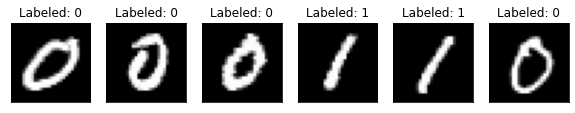

In [19]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets[0].item()))
    
    n_samples_show -= 1

In [20]:
n_samples = 50

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=True)

In [21]:
# define QNN
feature_map = ZZFeatureMap(2)
ansatz = RealAmplitudes(2, reps=1)
qnn4 = TwoLayerQNN(2, feature_map, ansatz, exp_val=AerPauliExpectation(), quantum_instance=qi)
print(qnn4.operator)

ComposedOp([
  OperatorMeasurement(1.0 * ZZ),
  CircuitStateFn(
       ┌──────────────────────────┐┌──────────────────────────────────────┐
  q_0: ┤0                         ├┤0                                     ├
       │  ZZFeatureMap(x[0],x[1]) ││  RealAmplitudes(θ[0],θ[1],θ[2],θ[3]) │
  q_1: ┤1                         ├┤1                                     ├
       └──────────────────────────┘└──────────────────────────────────────┘
  )
])


In [22]:
class Net(Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(256, 64)
        self.fc2 = Linear(64, 2)         # 2-dimensional input to QNN
        self.qnn = TorchConnector(qnn4)  # 
        self.fc3 = Linear(1, 1)          # 1-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc3(x)
        return cat((x, 1 - x), -1)
    
model4 = Net()

In [23]:
# define model, optimizer, and loss function
optimizer = optim.Adam(model4.parameters(), lr=0.001)
loss_func = NLLLoss()

# start training
epochs = 10     # set number of epochs
loss_list = []  # store loss history
model4.train()  # set model to training mode
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):        
        optimizer.zero_grad(set_to_none=True)  # initialize gradient
        output = model4(data)                   # forward pass
        loss = loss_func(output, target)       # calculate loss
        loss.backward()                        # backward pass
        optimizer.step()                       # optimize weights
        total_loss.append(loss.item())         # store loss    
    loss_list.append(sum(total_loss)/len(total_loss))    
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

Training [10%]	Loss: -0.4920
Training [20%]	Loss: -0.4879
Training [30%]	Loss: -0.4973
Training [40%]	Loss: -0.4934
Training [50%]	Loss: -0.5047
Training [60%]	Loss: -0.4952
Training [70%]	Loss: -0.4949
Training [80%]	Loss: -0.4971
Training [90%]	Loss: -0.4994
Training [100%]	Loss: -0.4940


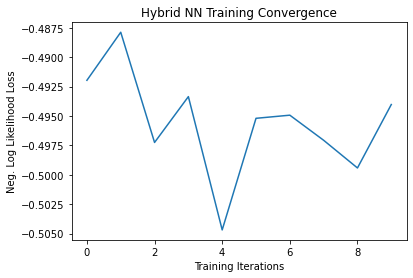

In [24]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg. Log Likelihood Loss')
plt.show()

In [25]:
model4.eval()  # set model to evaluation mode
with no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model4(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'
          .format(sum(total_loss) / len(total_loss), 
                  correct / len(test_loader) / batch_size * 100)
    )

Performance on test data:
	Loss: -0.4962
	Accuracy: 50.0%


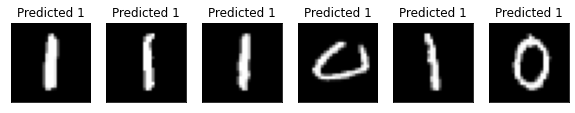

In [26]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model4.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model4(data[0:1])
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)
        
        pred = output.argmax(dim=1, keepdim=True) 

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        
        count += 1

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright